In [2]:
import numpy as np
import os
import pandas as pd
import h5py
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox.utils import set_random_seed

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [4]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [5]:
# set random seed for reproducibility
set_random_seed(seed=42)

2025-12-01 21:06:39.205541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-01 21:06:39.205565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


Seed set to 42


# Distribution of distances between hgp's

Ran these first:

In [ ]:
# awk 'BEGIN{OFS="\t"} $1 ~ /^chr([0-9]+|X|Y|M)$/ {print}' gm12878_h3k27ac_peaks.gappedPeak > gm12878_h3k27ac_peaks.gappedPeak.canonical.temp
# sort -k1,1V -k2,2n *.temp > gm12878_h3k27ac_peaks.gappedPeak.canonical.temp.sorted
# sort -c -k1,1V -k2,2n *.temp.sorted
# echo $?
# > 0

In [18]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"

# read histone peaks (3-column BED assumed: chrom, start, end)
histone_bed = os.path.join(base_dir, "maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted")
histone_df = pl.read_csv(
   histone_bed,
    separator="\t",
    has_header=False,
    new_columns=["chrom", "chromStart", "chromEnd"],
).select(["chrom", "chromStart", "chromEnd"])
assert len(histone_df.unique()) == len(histone_df)
print(histone_df.unique().shape, histone_df.shape)

# read chromosome sizes
chr_sizes = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
chr_sz_df = pl.read_csv(chr_sizes, separator="\t", has_header=False, new_columns=["chrom", "chrom_size"])

# add chromosome sizes to histone_df
histone_df = histone_df.join(
    chr_sz_df, left_on="chrom", right_on="chrom", how="left",
)
assert histone_df["chrom_size"].is_null().sum() == 0

# add length column
histone_df = histone_df.with_columns((pl.col("chromEnd") - pl.col("chromStart")).alias("length"))

histone_df_pd = histone_df.to_pandas()

(45097, 3) (45097, 3)


Computed distances for 45074 peak pairs.


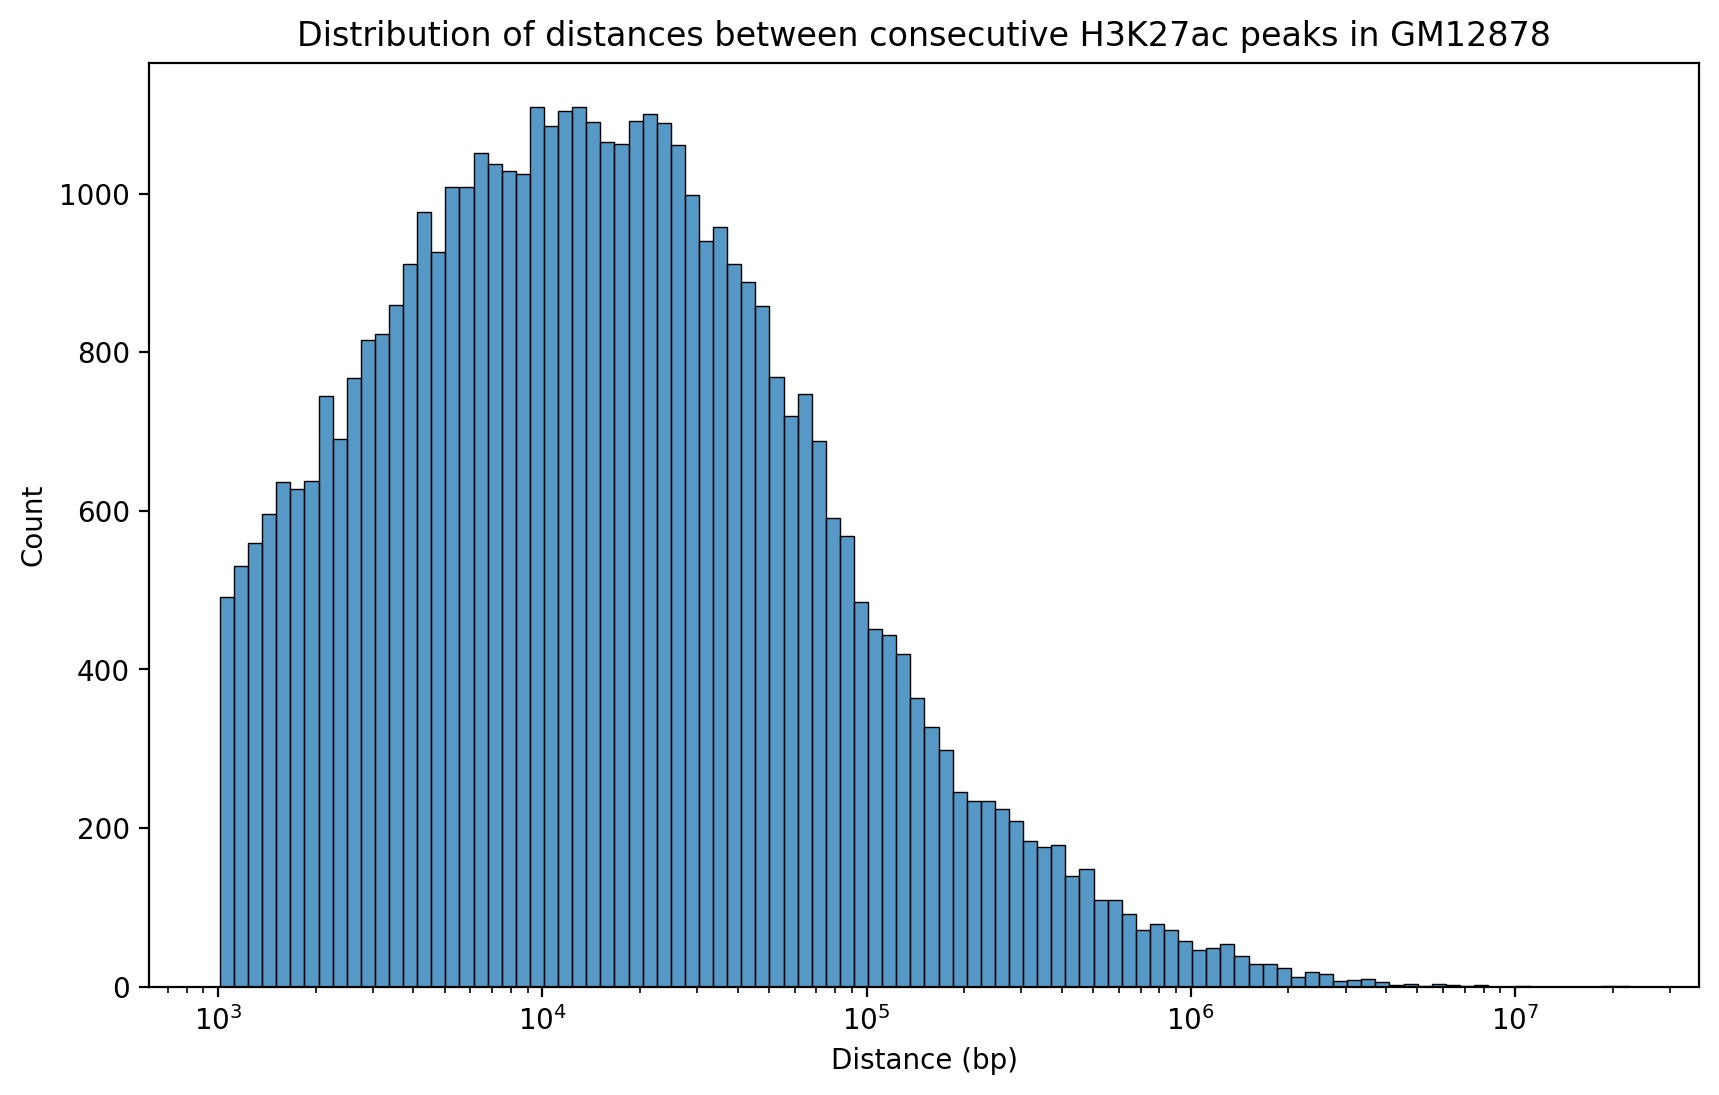

In [ ]:
# for each chromosome, compute distances between consecutive peaks, using chromEnd of previous peak and chromStart of current peak
# histone_df_pd is pandas
distances = []
for chrom in histone_df_pd["chrom"].unique():
    chrom_df = histone_df_pd[histone_df_pd["chrom"] == chrom].sort_values(by="chromStart")
    chrom_distances = chrom_df["chromStart"].values[1:] - chrom_df["chromEnd"].values[:-1]
    distances.extend(chrom_distances)
distances = np.array(distances)
print(f"Computed distances for {len(distances)} peak pairs.")
# plot distribution of distances
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=100, log_scale=(True, False))
plt.title("Distribution of distances between consecutive H3K27ac peaks in GM12878")
plt.xlabel("Distance (bp)")
plt.ylabel("Count")
# plt.xlim(0, 100000)
plt.show()

In [24]:
pd.Series(distances).describe()

count    4.507400e+04
mean     6.285759e+04
std      2.592949e+05
min      1.012000e+03
25%      4.834250e+03
50%      1.412600e+04
75%      4.236850e+04
max      2.245720e+07
dtype: float64

^ In particular this shows that there are no overlapping hgp's, since there are no negative distances.

In [25]:
def run_for_window(window: int):
    print("*** Running for window size: ", window)

    # read atac peaks, keep only chrom, chromStart, chromEnd
    atac_bed = os.path.join(base_dir, f"ENCFF748UZH.summits.{window}bp.sorted.bed.gz" if window > 1 else f"ENCFF748UZH.summits.sorted.bed.gz")
    atac_df = pl.read_csv(
        atac_bed,
        separator="\t",
        has_header=False,
        new_columns=[
            "chrom", "chromStart", "chromEnd", "name", "score", "strand",
        ],
    ).select(["chrom", "chromStart", "chromEnd"])

    # select cols
    histone_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir,"temp_A.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir,"temp_B.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html
    fn_prefix = f"gapped_peak_histone_intersect_{str(window)}bp"
    cmd = f"cd {base_dir} && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -F 1 -c > {fn_prefix}_atac_counts_only.bed && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -F 1 > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

    # plot distribution of intersection counts
    counts_df = pl.read_csv(
        os.path.join(base_dir, f"{fn_prefix}_atac_counts_only.bed"),
        separator="\t",
        has_header=False,
        new_columns=["chrom", "start", "end", "counts"]
    )
    sns.histplot(counts_df["counts"], bins=100, kde=False)
    plt.xlabel(f"{window}bp summit-centered Atac Peak Count")
    plt.ylabel("Count")
    plt.title(f"Distribution of ({window}bp summit-centered) Atac Peak Counts Overlapping Gapped Histone Peaks")
    # save plot
    plt.savefig(os.path.join(base_dir, f"{fn_prefix}_atac_counts_distribution.png"), dpi=300)
    plt.close()

    # extend histone peaks: extremities ± 1k bp
    X = 1_000

    extended = histone_df.with_columns([
        (pl.col("chromStart") - X).clip(0,None).alias("start_ext_clipped"),  # avoid negative starts
        (pl.col("chromEnd") + X).clip(0, pl.col("chrom_size")).alias("end_ext_clipped"),  # avoid exceeding chrom size
    ])

    # make sure all extended peaks have length <= 524288
    e = extended.with_columns([(pl.col("end_ext_clipped") - pl.col("start_ext_clipped")).alias("clipped_length_ext")])
    assert (e["clipped_length_ext"] > 524288).sum() == 0

    # select columns
    extended.select(["chrom", "start_ext_clipped", "end_ext_clipped"]).write_csv(
        os.path.join(base_dir,"temp_A.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir,"temp_B.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html
    cmd = f"cd {base_dir} && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -F 1 -c > extended_{fn_prefix}_atac_counts_only.bed && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -F 1 > extended_{fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

    # plot distribution of intersection counts
    counts_df = pl.read_csv(
        os.path.join(base_dir, f"extended_{fn_prefix}_atac_counts_only.bed"),
        separator="\t",
        has_header=False,
        new_columns=["chrom", "start", "end", "counts"]
    )
    sns.histplot(counts_df["counts"], bins=100, kde=False)
    plt.xlabel(f"{window}bp summit-centered Atac Peak Count")
    plt.ylabel("Count")
    plt.title(f"Distribution of ({window}bp summit-centered) Atac Peak Counts Overlapping Extended Gapped Histone Peaks")
    # save plot
    plt.savefig(os.path.join(base_dir, f"extended_{fn_prefix}_atac_counts_distribution.png"), dpi=300)
    plt.close()

In [20]:
run_for_window(1)

*** Running for window size:  1


In [27]:
run_for_window(2114)

*** Running for window size:  2114


# Reverse join

We need to do the reverse, ie for each atac peak find how many hgp's overlap it.

Ran a slightly modified narrowPeaks_to_summits.sh to generated 2114bp summit-centered atac peaks.

In [62]:
def run_for_window_reverse(window: int, base_dir_override = None, atac_bed = None):
    print("*** Running for window size: ", window)

    if base_dir_override is None:
        base_dir_override = base_dir

    # read atac peaks, keep only chrom, chromStart, chromEnd
    if atac_bed is None:
        atac_bed = os.path.join(base_dir_override, f"ENCFF748UZH.summits.{window}bp.sorted.bed.gz" if window > 1 else f"ENCFF748UZH.summits.sorted.bed.gz")
    atac_df = pl.read_csv(
        atac_bed,
        separator="\t",
        has_header=False,
        new_columns=[
            "chrom", "chromStart", "chromEnd", "name", "score", "strand",
        ],
    ).select(["chrom", "chromStart", "chromEnd"])

    # select cols
    histone_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_B.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_A.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html
    fn_prefix = f"reverse_gapped_peak_histone_intersect_{str(window)}bp"
    cmd = f"cd {base_dir_override} && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -f 1 -c > {fn_prefix}_atac_counts_only.bed && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -f 1 > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

    # plot distribution of intersection counts
    counts_df = pl.read_csv(
        os.path.join(base_dir_override, f"{fn_prefix}_atac_counts_only.bed"),
        separator="\t",
        has_header=False,
        new_columns=["chrom", "start", "end", "counts"]
    )
    sns.histplot(counts_df["counts"], bins=100, kde=False)
    plt.xlabel("Gapped Histone Peak Count")
    plt.ylabel("Count")
    plt.title(f"Distribution of Gapped Histone Peak Count Overlapping ({window}bp summit-centered) Atac Peak")
    # save plot
    plt.savefig(os.path.join(base_dir_override, f"{fn_prefix}_atac_counts_distribution.png"), dpi=300)
    plt.close()
    counts_df_normal = counts_df.to_pandas().copy()

    # extend histone peaks: extremities ± 1k bp
    X = 1_000
    fn_prefix = f"reverse_extended_gapped_peak_histone_intersect_{str(window)}bp"

    # extended = histone_df.with_columns([
    #     (pl.col("chromStart") - X).clip(0,None).alias("start_ext_clipped"),  # avoid negative starts
    #     (pl.col("chromEnd") + X).clip(0, pl.col("chrom_size")).alias("end_ext_clipped"),  # avoid exceeding chrom size
    # ])

    # instead of clipping, discard peaks
    extended = histone_df.with_columns([
        (pl.col("chromStart") - X).alias("start_ext"),  
        (pl.col("chromEnd") + X).alias("end_ext"),
    ])
    # avoid negative starts and exceeding chrom size
    extended = extended.filter(
        (pl.col("start_ext") >= 0) & 
        (pl.col("end_ext") <= pl.col("chrom_size"))
    )

    # make sure all extended peaks have length <= 524288
    e = extended.with_columns([(pl.col("end_ext") - pl.col("start_ext")).alias("clipped_length_ext")])
    assert (e["clipped_length_ext"] > 524288).sum() == 0

    # select columns
    extended.select(["chrom", "start_ext", "end_ext"]).write_csv(
        os.path.join(base_dir_override,"temp_B.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_A.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html
    cmd = f"cd {base_dir_override} && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -f 1 -c > {fn_prefix}_atac_counts_only.bed && \
        bedtools intersect -a temp_A.bed -b temp_B.bed -loj -f 1 > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

    # plot distribution of intersection counts
    counts_df = pl.read_csv(
        os.path.join(base_dir_override, f"{fn_prefix}_atac_counts_only.bed"),
        separator="\t",
        has_header=False,
        new_columns=["chrom", "start", "end", "counts"]
    )
    sns.histplot(counts_df["counts"], bins=100, kde=False)
    plt.xlabel(f"Extended Gapped Histone Peak Count")
    plt.ylabel("Count")
    plt.title(f"Distribution of Extended Gapped Histone Peak Count Overlapping ({window}bp summit-centered) Atac Peak")
    # save plot
    plt.savefig(os.path.join(base_dir_override, f"{fn_prefix}_atac_counts_distribution.png"), dpi=300)
    plt.close()

    return counts_df_normal, counts_df.to_pandas()

Given the distirbiuton of between-hgp distances, in partuclar no overallping hgp's, I expect the "-f 1" intersections to return no more than one overlapping hgp per atac peak in all cases.

Given the distirbiuton of between-hgp distances, in paritcular that min distance is ~10^3, I expect the "-f 1" intersections to return no more than one overlapping hgp per atac peak in the case of 2114 width atac peaks, but in the case of 1bp width atac peaks, one atac peak might overlap two hgp's if they are close enough. See atac_hist_peak_overlap.png, and an example below.

In [42]:
cdf_n_1, cdf_1 = run_for_window_reverse(1)
cdf_n_2114, cdf_2114 = run_for_window_reverse(2114)

*** Running for window size:  1
*** Running for window size:  2114


In [43]:
cdf_n_2114["counts"].describe()

count    277999.000000
mean          0.170101
std           0.375722
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: counts, dtype: float64

In [44]:
cdf_2114["counts"].describe()

count    277999.000000
mean          0.443735
std           0.496825
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: counts, dtype: float64

In [45]:
(cdf_2114["counts"] > 1).sum(), (cdf_1["counts"] > 1).sum(), (cdf_n_2114["counts"] > 1).sum(), (cdf_n_1["counts"] > 1).sum()

(0, 160, 0, 0)

As expected most are 0, but the cdf_1 has some non zeros.

In [40]:
cdf_1[cdf_1["counts"] > 1]

,chrom,start,end,counts
1226,chr1,9590880,9590881,2
1227,chr1,9591095,9591096,2
12342,chr1,110645406,110645407,2
21285,chr1,206288624,206288625,2
23425,chr1,224752056,224752057,2
...,...,...,...,...
269759,chrX,2709057,2709058,2
271477,chrX,21986836,21986837,2
271836,chrX,29541214,29541215,2
272607,chrX,41798306,41798307,2


In [ ]:
87817	91113
90164	92740

In [49]:
9587817+1000, 9591113-1000, 9590164+1000, 9592740-1000

(9588817, 9590113, 9591164, 9591740)

In [50]:
9591164 - 9590113

1051

In [52]:
cdf_2114["counts"].describe()

count    277999.000000
mean          0.443735
std           0.496825
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: counts, dtype: float64

In [53]:
100 * (cdf_2114["counts"] == 1).sum() / len(cdf_2114)

44.37354091201767

In [54]:
100 * (cdf_n_2114["counts"] == 1).sum() / len(cdf_n_2114)

17.010133129975287

Hmm so we "lose" quite a lot of the atac peaks if the (positive) peaks are only the ones that fully overlap an hgp (we cant assign an hgp to the others then).

In [55]:
len(cdf_n_2114), len(cdf_2114)

(277999, 277999)

Makes sense that both are the same, that s the total count of atac peaks ^

Now save the version we actually want to use for training:

In [74]:
p ="/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/reverse_extended_gapped_peak_histone_intersect_2114bp_atac.bed"
df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"]
)
df = df[df["hist_chrom"] != "."]
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data"
df.to_csv(os.path.join(p, "reverse_extended_gapped_peak_histone_intersect_2114bp_atac_full_overlap.bed"), sep="\t", index=False, header=False)

Nvm I acutlaly need to do with the peaks that anusri used for training the gm12878 atac:

In [11]:
bdo = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data"
cdf_n2, cdf2 = run_for_window_reverse(
    2114,
    base_dir_override=bdo,
    atac_bed=os.path.join(bdo, "peaks.all_input_regions.ENCSR868FGK.summits.2114bp.sorted.bed.gz"),
)

NameError: name 'run_for_window_reverse' is not defined

In [66]:
cdf_n2["counts"].describe()

count    269718.000000
mean          0.081211
std           0.273159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: counts, dtype: float64

In [67]:
cdf2["counts"].describe()

count    269718.000000
mean          0.236436
std           0.424894
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: counts, dtype: float64

In [70]:
100 * (cdf2["counts"] == 1).sum() / len(cdf2)

23.64358329811136

In [71]:
100 * (cdf_n2["counts"] == 1).sum() / len(cdf_n2)

8.121074603845498

In [73]:
len(cdf_n2), len(cdf2)

(269718, 269718)

The stats are kind of worst here since only 24 ish percent of the atac peaks have an overlapping hgp...

Delete a bunch of the useless files, like:

histobpnet_v2/data/reverse_extended_gapped_peak_histone_intersect_2114bp_atac_counts_distribution.png
histobpnet_v2/data/reverse_gapped_peak_histone_intersect_2114bp_atac_counts_distribution.png
histobpnet_v2/data/reverse_gapped_peak_histone_intersect_2114bp_atac_counts_only.bed
histobpnet_v2/data/reverse_gapped_peak_histone_intersect_2114bp_atac_full_overlap.bed

Take the actual peaks to use for training.

In [16]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/reverse_extended_gapped_peak_histone_intersect_2114bp_atac.bed"
df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"]
)
# df = df[df["hist_chrom"] != "."]

In [7]:
df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,39778,41892,.,-1,-1
1,chr1,40034,42148,.,-1,-1
2,chr1,40545,42659,.,-1,-1
3,chr1,41223,43337,.,-1,-1
4,chr1,45439,47553,.,-1,-1
...,...,...,...,...,...,...
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1


In [9]:
!zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data/peaks.all_input_regions.ENCSR868FGK.summits.2114bp.sorted.bed.gz  | wc -l

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
269718


In [12]:
df[df["hist_chrom"] != "."].shape[0] / len(df)

0.23643583298111362

Fix the start and end

In [17]:
idx = df["hist_chrom"] != "."
df.loc[idx, "hist_start"] = df.loc[idx, "hist_start"] + 1000
df.loc[idx, "hist_end"] = df.loc[idx, "hist_end"] - 1000

In [18]:
df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,39778,41892,.,-1,-1
1,chr1,40034,42148,.,-1,-1
2,chr1,40545,42659,.,-1,-1
3,chr1,41223,43337,.,-1,-1
4,chr1,45439,47553,.,-1,-1
...,...,...,...,...,...,...
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1


In [19]:
df[df["hist_end"] < -1]

,chrom,start,end,hist_chrom,hist_start,hist_end


In [20]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data"
df.to_csv(os.path.join(p, "reverse_extended_gapped_peak_histone_intersect_2114bp_atac_for_train.bed"), sep="\t", index=False, header=True)

In [16]:
import pandas as pd
import os
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/data"
df = pd.read_csv(
    os.path.join(p, "reverse_extended_gapped_peak_histone_intersect_2114bp_atac_for_train.bed"),
    sep="\t",
    header=0,
)
# search for rows with chrom, start, end equal to a specific values
df
idx = (df["chrom"] =="chr1") & (df["start"] == 39778) & (df["end"] == 41892)
idx.sum()

1

In [19]:
df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,39778,41892,.,-1,-1
1,chr1,40034,42148,.,-1,-1
2,chr1,40545,42659,.,-1,-1
3,chr1,41223,43337,.,-1,-1
4,chr1,45439,47553,.,-1,-1
...,...,...,...,...,...,...
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1
